# A/B Test Analysis with Bayesian Statistics
This notebook performs an end-to-end analysis of A/B test results using Bayesian statistical methods. The objective is to go beyond the traditional "p-value" to calculate the probability of each variant being the best and to quantify the expected risk associated with choosing one variant over another.

## 1. Setup
The next two cells begins by setting up the environment. First, it imports the essential Python libraries: pandas for data manipulation, numpy for numerical operations, scipy.stats for statistical functions, and matplotlib/seaborn for visualization.

Next, it defines the core parameters for the analysis:

- FILE_NAME: The name of the input data file.

- PRIOR_ALPHA & PRIOR_BETA: The initial parameters for our Bayesian model, set to 1.0 to represent an uninformative prior.

- RISK_THRESHOLD: The pre-defined risk tolerance that will be used to make the final decision.

The main objective is to use this setup to go beyond the traditional "p-value" to calculate the probability of each variant being the best and to quantify the expected risk associated with choosing one variant over another.

In [22]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Global Parameter Definition

# This cell centralizes all the key parameters and constants that will be used
# throughout the notebook. This makes it easy to adjust the analysis settings
# without searching through the entire code.

# --- File Configuration ---
# The name of the Excel file containing the A/B test data.
# The project description specifies that this file should be in the same
# directory as the notebook.
FILE_NAME = 'data_ab.xlsx'


# --- Bayesian Prior Configuration ---
# These parameters define our prior belief about the conversion rate before
# observing any data.
#
# By setting alpha and beta to 1.0, we are using a Beta(1, 1) distribution,
# which is mathematically equivalent to a Uniform(0, 1) distribution. This is a
# common "uninformative prior" used when we have no strong initial assumptions
# about what the conversion rate might be.
PRIOR_ALPHA = 1.0
PRIOR_BETA = 1.0


# --- Decision Framework Configuration ---
# This defines the risk tolerance for making a decision. The Expected Loss
# (the risk) of choosing a variant will be compared against this threshold.
#
# A value of 0.01 means we will only recommend a winning variant if the
# potential downside of making that choice is less than 1% of the conversion rate.
# This value establishes a clear, pre-defined rule for the final recommendation.
RISK_THRESHOLD = 0.01

## 2. Data Loading and Validation
This cell handles the critical first step of loading and validating the A/B test data. The code will read the specified Excel file, confirm its existence, and verify that it contains the necessary columns for the analysis: variante, visitantes, and conversoes. This ensures the data is correctly structured before proceeding.

In [24]:
# Data Loading and Validation
import os # The 'os' library is used here to check for file existence

# --- Define Expected Data Structure ---
# These are the column names the script expects to find in the Excel file.
# The analysis logic depends on these specific columns being present.
REQUIRED_COLUMNS = ['variante', 'visitantes', 'conversoes']

print(f"Attempting to load data from '{FILE_NAME}'...")

# --- Validation and Loading Logic ---
# First, check if the file exists in the directory.
if not os.path.exists(FILE_NAME):
    # If the file is not found, print a clear error and stop.
    print(f"---")
    print(f"Error: File Not Found.")
    print(f"The data file '{FILE_NAME}' was not found in the current directory.")
    print(f"Please ensure the file is present before proceeding.")

else:
    # If the file exists, try to load and validate it.
    try:
        # Load the Excel file into a pandas DataFrame.
        df = pd.read_excel(FILE_NAME)

        # Check if all the required columns are in the DataFrame.
        if all(col in df.columns for col in REQUIRED_COLUMNS):
            # If validation is successful, print a confirmation and the data's head.
            print("Success: File loaded and validated.")
            print("\n--- First 5 Rows of the Dataset ---")
            # Display the first 5 rows for a quick visual inspection.
            # Using display() is ideal for Jupyter notebooks for better formatting.
            display(df.head())
        else:
            # If columns are missing, identify them and report the error.
            missing_cols = [col for col in REQUIRED_COLUMNS if col not in df.columns]
            print(f"---")
            print(f"Error: Missing Columns.")
            print(f"The file '{FILE_NAME}' was loaded, but is missing required columns.")
            print(f"Missing column(s): {missing_cols}")
            print(f"Please ensure the file contains all of the following columns: {REQUIRED_COLUMNS}")

    except Exception as e:
        # Catch any other potential errors during the file reading process.
        print(f"---")
        print(f"An unexpected error occurred while reading the file: {e}")

Attempting to load data from 'data_ab.xlsx'...
Success: File loaded and validated.

--- First 5 Rows of the Dataset ---


,variante,visitantes,conversoes
0,A,10000,300
1,B,10000,350
2,C,9900,315


## 3. Calculation of Posterior Parameters
Here, we perform the core Bayesian update for our A/B test. 🧪

This cell calculates the **posterior parameters** (`alpha` and `beta`) for each variant by combining our initial **prior beliefs** with the observed data. The formulas are straightforward:

-   `posterior_alpha = prior_alpha + conversoes`
-   `posterior_beta = prior_beta + (visitantes - conversoes)`

These new parameters define the posterior Beta distribution for each variant, representing our updated understanding of the true conversion rate after seeing the data.

In [25]:
# Calculation of Posterior Parameters

# This cell applies the core Bayesian update rule for the Beta-Binomial model.
# The 'posterior' distribution represents our updated belief about the conversion
# rate after incorporating the evidence from the collected data.

# For a Beta-Binomial model, the posterior parameters are calculated as follows:
# posterior_alpha = prior_alpha + number_of_successes (conversions)
# posterior_beta = prior_beta + number_of_failures (visitors - conversions)

# Check if the dataframe 'df' exists to prevent errors if previous cells failed.
if 'df' in locals():
    # Calculate the posterior alpha parameter for each variant.
    df['posterior_alpha'] = PRIOR_ALPHA + df['conversoes']

    # Calculate the posterior beta parameter for each variant.
    df['posterior_beta'] = PRIOR_BETA + (df['visitantes'] - df['conversoes'])


    # --- Display the Updated DataFrame ---
    # Show the DataFrame with the newly calculated posterior parameters.
    # These parameters fully define the probability distributions for the
    # conversion rate of each variant.

    print("--- DataFrame with Posterior Parameters ---")
    display(df)

else:
    print("Error: The DataFrame 'df' does not exist.")
    print("Please ensure the data loading and validation cell (Cell 5) was executed successfully.")

--- DataFrame with Posterior Parameters ---


,variante,visitantes,conversoes,posterior_alpha,posterior_beta
0,A,10000,300,301.0,9701.0
1,B,10000,350,351.0,9651.0
2,C,9900,315,316.0,9586.0


## 4. Generation of the Posterior Plot

This cell generates the most important visualization for our analysis: the posterior probability distributions. 📊

The code plots a curve for each variant, representing our final belief about its true conversion rate. This allows for a direct visual comparison. Pay attention to two key aspects of the curves:

-   **Position**: A curve shifted to the right indicates a higher probable conversion rate.
-   **Shape**: A taller, narrower curve signifies greater certainty about the conversion rate's value.

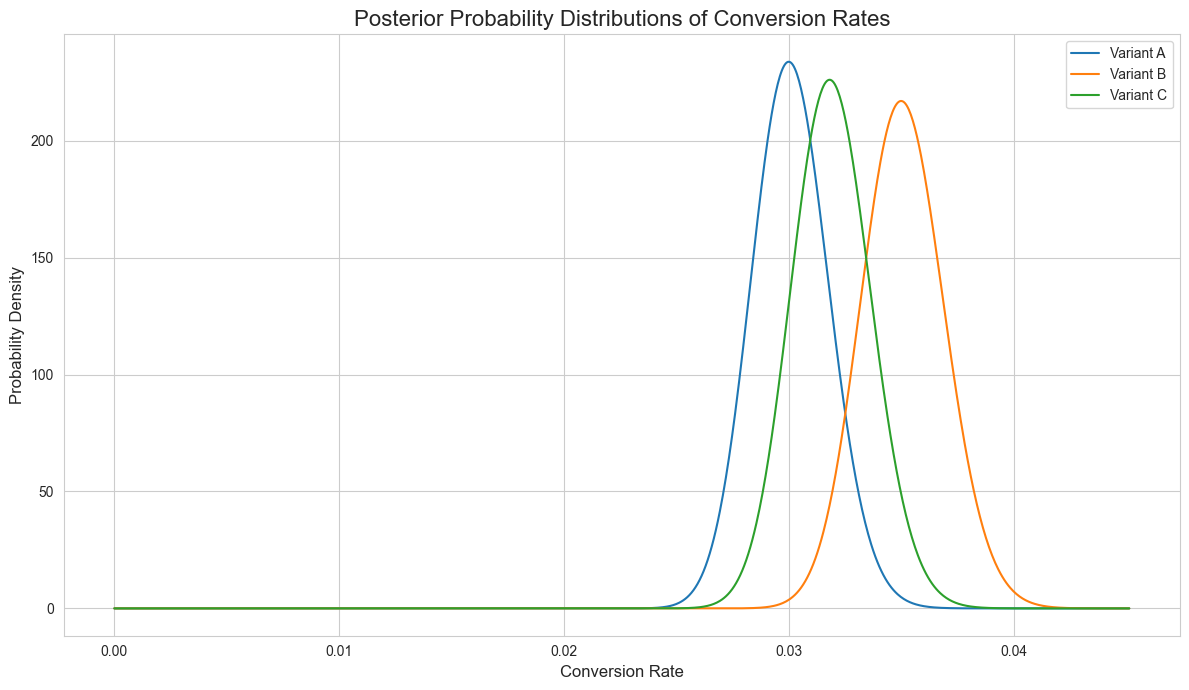

In [26]:
# Generation of the Posterior Plot

# This cell visualizes the posterior distributions for each variant.
# Each curve represents the range of probable values for the true conversion
# rate of a variant, given the data. Taller, narrower curves indicate more
# certainty about the conversion rate.

# Check if the dataframe 'df' with posterior columns exists to prevent errors.
if 'df' in locals() and 'posterior_alpha' in df.columns:

    # --- 1. Setup for Plotting ---
    # Create a figure to hold the plot.
    plt.figure(figsize=(12, 7))

    # To make the plot robust, we dynamically determine a suitable range for the x-axis.
    # We'll find the 99.9th percentile of each distribution and set the limit
    # just beyond the maximum of these to ensure all curves are fully visible.
    max_x = 0
    for i, row in df.iterrows():
        # Calculate the value at which 99.9% of the distribution is covered
        percentile_999 = stats.beta.ppf(0.999, row['posterior_alpha'], row['posterior_beta'])
        if percentile_999 > max_x:
            max_x = percentile_999

    # Create a smooth range of x-values (conversion rates) for plotting the curves.
    # We add 10% padding to the max value for better visualization.
    x = np.linspace(0, max_x * 1.1, 1000)

    # --- 2. Plot Each Variant's Posterior Distribution ---
    # Iterate over each variant (row) in the DataFrame.
    for i, row in df.iterrows():
        # Get the parameters and name for the current variant.
        variant_name = row['variante']
        p_alpha = row['posterior_alpha']
        p_beta = row['posterior_beta']

        # Calculate the Probability Density Function (PDF) for the Beta distribution.
        pdf = stats.beta.pdf(x, p_alpha, p_beta)

        # Plot the PDF curve with a label for the legend.
        plt.plot(x, pdf, label=f'Variant {variant_name}')


    # --- 3. Finalize and Display the Plot ---
    # Add a clear title and labels as specified in the project description.
    plt.title('Posterior Probability Distributions of Conversion Rates', fontsize=16)
    plt.xlabel('Conversion Rate', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)

    # Display the legend to identify which curve corresponds to which variant.
    plt.legend()

    # Improve layout
    plt.tight_layout()

    # Render the plot.
    plt.show()

else:
    print("Error: DataFrame 'df' with posterior parameters not found.")
    print("Please ensure the data loading (Cell 5) and posterior calculation (Cell 7) were executed successfully.")

## 5. # Monte Carlo Simulation
While the plot provided a visual comparison, we need to quantify the results to make a decision. To do this, we'll run a **Monte Carlo simulation**. 🎰

The code below draws a large number (`100,000`) of random samples from each variant's posterior Beta distribution. Each sample can be thought of as a plausible "true conversion rate" for that variant, according to our model.

By creating these large sets of simulated outcomes, we can directly compare them to calculate precise metrics in the following steps, such as the probability of one variant being superior to another.

In [27]:
# Monte Carlo Simulation

# This cell performs a Monte Carlo simulation to draw random samples from the
# posterior distribution of each variant. These samples will allow us to
# empirically compare the variants and calculate key metrics, such as the
# probability of one being better than the other and the expected loss.

# --- 1. Simulation Setup ---
# Define the number of random samples to generate for each variant's distribution.
# A larger number of samples leads to more stable and accurate estimates of our metrics.
N_SAMPLES = 100000

# We will store the generated samples in a dictionary, with variant names as keys.
posterior_samples = {}


# --- 2. Run Simulation ---
# Check if the dataframe 'df' with posterior parameters exists to avoid errors.
if 'df' in locals() and 'posterior_alpha' in df.columns:

    # Iterate over each variant (row) in the DataFrame.
    for i, row in df.iterrows():
        variant_name = row['variante']
        p_alpha = row['posterior_alpha']
        p_beta = row['posterior_beta']

        # Generate N_SAMPLES from the Beta distribution defined by the variant's
        # posterior parameters. Each sample represents a plausible "true"
        # conversion rate for that variant, according to our model.
        samples = stats.beta.rvs(a=p_alpha, b=p_beta, size=N_SAMPLES)

        # Store the resulting array of samples in our dictionary.
        posterior_samples[variant_name] = samples

    # --- 3. Output: Simulation Summary ---
    # The simulation is complete. The following is a summary of the process.
    print("--- Monte Carlo Simulation Summary ---")
    print(f"✅ Simulation completed successfully.")
    print(f"   - Samples generated per variant: {N_SAMPLES:,}")
    print(f"   - Variants simulated: {list(posterior_samples.keys())}")

    print("\nData Preview (first 3 samples for each variant):")
    for variant, samples in posterior_samples.items():
        preview = [round(s, 6) for s in samples[:3]]
        print(f"  - {variant}: {preview}")

    print("\nThe 'posterior_samples' dictionary is now ready for metric calculation in the next cell.")

else:
    # This message will only be displayed if the prerequisite DataFrame is not found.
    print("Error: DataFrame 'df' with posterior parameters not found.")
    print("Please ensure the data loading (Cell 5) and posterior calculation (Cell 7) were executed successfully.")

--- Monte Carlo Simulation Summary ---
✅ Simulation completed successfully.
   - Samples generated per variant: 100,000
   - Variants simulated: ['A', 'B', 'C']

Data Preview (first 3 samples for each variant):
  - A: [0.030647, 0.030826, 0.032076]
  - B: [0.036513, 0.035059, 0.032998]
  - C: [0.030152, 0.034342, 0.029762]

The 'posterior_samples' dictionary is now ready for metric calculation in the next cell.


## 6. Calculation and Presentation of Metrics
This is the final calculation step where we translate our simulation results into actionable business metrics. 🏆

The code below uses the thousands of simulated outcomes to compute two key metrics for each variant:

1.  **Probability of Being Best**: The percentage of simulations where a variant had the highest conversion rate. This answers the question: "Which variant is most likely the winner?"
2.  **Expected Loss (Risk)**: The average "regret" or loss we would incur by choosing a variant if another one was actually better. This answers the question: "What is the cost of being wrong?"

The results will be sorted by risk, providing a clear recommendation for which variant is the optimal choice from a risk-management perspective.

In [28]:
# Calculation and Presentation of Metrics

# This cell uses the simulated samples to calculate the final decision metrics
# for any number of variants.

# Check if the 'posterior_samples' dictionary exists and is populated.
if 'posterior_samples' in locals() and len(posterior_samples) >= 1:

    # --- 1. Consolidate All Samples ---
    variant_names = list(posterior_samples.keys())
    # Stack all sample arrays into a single 2D NumPy array for efficient calculation
    # Shape will be (number_of_variants, N_SAMPLES)
    all_samples_array = np.stack([posterior_samples[name] for name in variant_names])

    # --- 2. Calculate Key Metrics for Each Variant ---

    # Find the best performing variant in each of the N_SAMPLES simulations
    best_variant_samples = all_samples_array.max(axis=0)

    # Find the index (0, 1, 2, etc.) of the winning variant in each simulation
    best_variant_indices = all_samples_array.argmax(axis=0)

    results = []
    # Now, loop through each variant to calculate its specific metrics
    for i, name in enumerate(variant_names):

        # i) Probability of Being Best
        # The proportion of simulations where this variant was the winner
        prob_is_best = np.mean(best_variant_indices == i)

        # ii) Expected Loss (Risk)
        # The average loss incurred if we choose this variant, but another was better
        samples_for_this_variant = all_samples_array[i]
        expected_loss = np.mean(best_variant_samples - samples_for_this_variant)

        results.append({
            "name": name,
            "prob_best": prob_is_best,
            "expected_loss": expected_loss
        })

    # --- 3. Format and Display Results ---
    print("--- Bayesian A/B Test Results ---")
    print("Metrics calculated for each variant:\n")

    # Sort results by the lowest risk for clearer presentation
    sorted_results = sorted(results, key=lambda x: x['expected_loss'])

    for result in sorted_results:
        print(f"Variant: '{result['name']}'")
        print(f"  - Probability of being the best: {result['prob_best']:.1%}")
        print(f"  - Risk (Expected Loss): {result['expected_loss']:.6f}")
        print("-" * 35)

    print("(Risk is the average amount you stand to lose by choosing this variant if another one was actually better.)")


else:
    print("Error: The 'posterior_samples' dictionary is not available.")
    print("Please ensure the Monte Carlo simulation (Cell 11) was executed successfully.")

--- Bayesian A/B Test Results ---
Metrics calculated for each variant:

Variant: 'B'
  - Probability of being the best: 88.2%
  - Risk (Expected Loss): 0.000144
-----------------------------------
Variant: 'C'
  - Probability of being the best: 10.2%
  - Risk (Expected Loss): 0.003330
-----------------------------------
Variant: 'A'
  - Probability of being the best: 1.6%
  - Risk (Expected Loss): 0.005140
-----------------------------------
(Risk is the average amount you stand to lose by choosing this variant if another one was actually better.)


## 7. Automated Conclusion Logic
This final, automated cell translates our statistical results into a clear business recommendation. 🎯

The logic is straightforward:
1.  It takes our best variant (the one with the lowest **Expected Loss**).
2.  It compares its risk level against a predefined **Risk Threshold** (`RISK_THRESHOLD`).

Based on this comparison, the code will either give a "go" signal to implement the winning variant or recommend that the test is inconclusive because even the best option is too risky to deploy.

In [29]:
# Automated Conclusion Logic

# This final cell takes the sorted list of results and uses the single
# best-performing variant to make a final recommendation.

print("--- Automated Recommendation ---")

# We use a try-except block to provide a more specific error message.
try:
    # --- Decision Framework ---
    print(f"Decision Threshold (Max Acceptable Risk): {RISK_THRESHOLD:.4f}\n")

    # The results from Cell 12 are already sorted by lowest risk (Expected Loss).
    # We only need to evaluate the top candidate.
    best_candidate = sorted_results[0]
    best_variant_name = best_candidate['name']
    lowest_risk = best_candidate['expected_loss']

    # Compare the risk of the best variant against the threshold.
    if lowest_risk < RISK_THRESHOLD:
        print(f"✅ Recommendation: Implement Variant '{best_variant_name}'.")
        print(f"Justification: This variant has the lowest risk ({lowest_risk:.6f}), which is below the acceptable threshold.")

    # If even the best variant is too risky.
    else:
        print(f"⚠️ Recommendation: The test is inconclusive.")
        print(f"Justification: Even the best variant, '{best_variant_name}', has a risk ({lowest_risk:.6f}) that is higher than your threshold.")
        print("Consider collecting more data to reduce uncertainty.")

except NameError as e:
    # This block runs ONLY if a required variable (like 'sorted_results' or 'RISK_THRESHOLD') was not found.
    print(f"\n--- ERROR ---")
    print(f"Could not generate a recommendation because a required variable is missing.")
    print(f"Specific Error: {e}")
    print("\nThis confirms that a variable from a previous cell was not created successfully.")
    print("Please check the output of Cell 3 and Cell 12 to ensure they ran without issues.")

--- Automated Recommendation ---
Decision Threshold (Max Acceptable Risk): 0.0100

✅ Recommendation: Implement Variant 'B'.
Justification: This variant has the lowest risk (0.000144), which is below the acceptable threshold.
